In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/iitjee-neet-aims-students-questions-data/subjects-questions.csv


In [2]:
df = pd.read_csv("/kaggle/input/iitjee-neet-aims-students-questions-data/subjects-questions.csv")
df.head()

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122519 entries, 0 to 122518
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   eng      122519 non-null  object
 1   Subject  122519 non-null  object
dtypes: object(2)
memory usage: 1.9+ MB


In [4]:
df.Subject.value_counts(normalize=True)

Subject
Physics      0.313731
Chemistry    0.308254
Maths        0.270897
Biology      0.107118
Name: proportion, dtype: float64

<Axes: xlabel='Subject'>

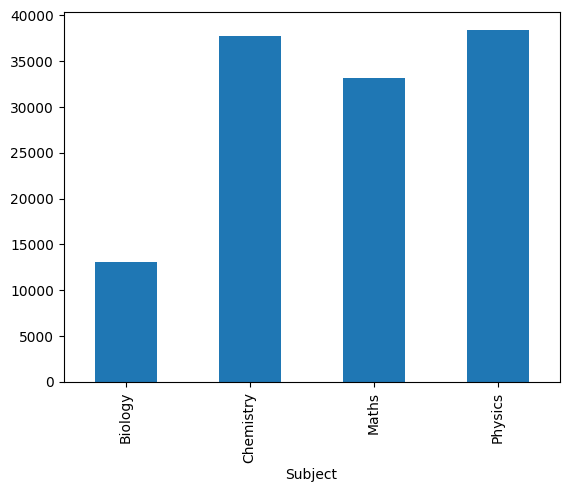

In [5]:
df.Subject.value_counts().sort_index().plot(kind='bar')

# Building a Text Classification System

## Data Preparation

In [6]:
! pip install textacy

In [7]:
import textacy
import textacy.preprocessing as tprep

In [8]:
import re


clean = tprep.make_pipeline(
    lambda text: re.sub(r"\n", " ", text),
    tprep.remove.punctuation,
    tprep.normalize.hyphenated_words,
    tprep.normalize.bullet_points,
    tprep.normalize.quotation_marks,
    tprep.normalize.whitespace,
)

In [9]:
from tqdm.notebook import tqdm

tqdm.pandas()

df['processed_text'] = df['eng'].progress_apply(clean)

  0%|          | 0/122519 [00:00<?, ?it/s]

In [10]:
df.processed_text.iloc[0]

'An anti forest measure is A Afforestation B Selective grazing C Clearing forest D Selective felling'

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(
    df['processed_text'], df['Subject'], test_size=0.2, random_state=42, stratify=df['Subject']
)

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  98015
Size of Test Data  24504


## Train a Simple Baseline

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier


base_pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(stop_words="english")),
        ('model', DummyClassifier(strategy='stratified', random_state=21))
    ]
)

base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('model',
                 DummyClassifier(random_state=21, strategy='stratified'))])

## Model Eval Metrics

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, classification_report


y_pred = base_pipeline.predict(X_test)


print(classification_report(y_test, y_pred, labels=base_pipeline.named_steps['model'].classes_))

              precision    recall  f1-score   support

     Biology       0.11      0.11      0.11      2625
   Chemistry       0.31      0.31      0.31      7553
       Maths       0.27      0.27      0.27      6638
     Physics       0.32      0.32      0.32      7688

    accuracy                           0.28     24504
   macro avg       0.25      0.25      0.25     24504
weighted avg       0.28      0.28      0.28     24504



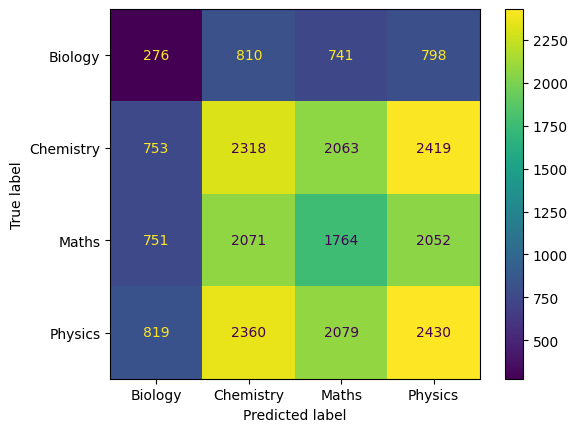

In [14]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_pipeline.named_steps['model'].classes_)
disp.plot()

## Apply a Simple ML Model

We will use SVM model because it works well with sparse matrixes which we have after TF-IDF vectorizer

In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV


svm_pipeline = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(stop_words="english", ngram_range=(1, 2))),
        ('model', LinearSVC(tol=1e-5, random_state=21))
    ]
)

hyperparams = [
    {
        'tfidf__min_df': [5, 10],
        'model__penalty': ['l2'],
        'model__loss': ['hinge'],
        'model__max_iter': [10000]
    }, 
    {
        'tfidf__min_df': [5, 10],
        'model__C': [1, 10],
        'model__tol': [1e-2, 1e-3]
    }
]

rs = RandomizedSearchCV(svm_pipeline, hyperparams, random_state=21, refit=True, cv=4, n_jobs=3)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              stop_words='english')),
                                             ('model',
                                              LinearSVC(random_state=21,
                                                        tol=1e-05))]),
                   n_jobs=3,
                   param_distributions=[{'model__loss': ['hinge'],
                                         'model__max_iter': [10000],
                                         'model__penalty': ['l2'],
                                         'tfidf__min_df': [5, 10]},
                                        {'model__C': [1, 10],
                                         'model__tol': [0.01, 0.001],
                                         'tfidf__min_df': [5, 10]}],
                   random_state=21)

In [16]:
svm_pipeline = rs.best_estimator_

y_pred = svm_pipeline.predict(X_test)

print(classification_report(y_test, y_pred, labels=svm_pipeline.named_steps['model'].classes_))

              precision    recall  f1-score   support

     Biology       0.93      0.91      0.92      2625
   Chemistry       0.92      0.92      0.92      7553
       Maths       0.96      0.97      0.96      6638
     Physics       0.93      0.93      0.93      7688

    accuracy                           0.94     24504
   macro avg       0.94      0.93      0.93     24504
weighted avg       0.94      0.94      0.94     24504



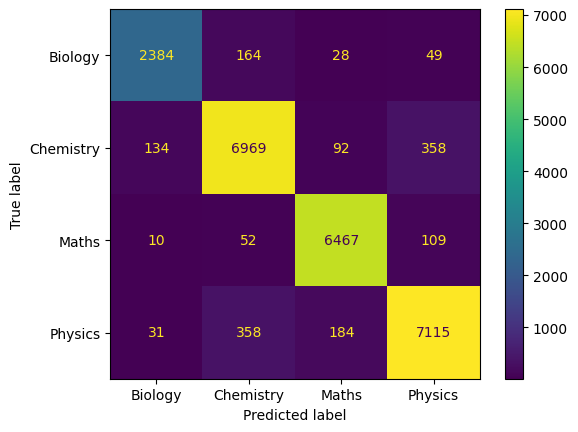

In [17]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_pipeline.named_steps['model'].classes_)
disp.plot()

# Explain the ML Model

We built a machine learning model but how does certain predictions done? More specially if somebody asks you about a certain case why the model predict a wrong label for it, we should be able to explain it. We will be using shap package for this.

In [18]:
import shap

tfidf, model = svm_pipeline.named_steps['tfidf'], svm_pipeline.named_steps['model']

In [19]:
shap.initjs()

explainer = shap.Explainer(
    model, tfidf.transform(X_train), feature_names=tfidf.get_feature_names_out()
)

In [20]:
sample_test_df = X_test.sample(frac=0.05)
shap_values = explainer(tfidf.transform(sample_test_df))    # Use a sample data to avoid OOM

## Feature Values for Each Class

We will see which words in our text data contributed to certain classes more.

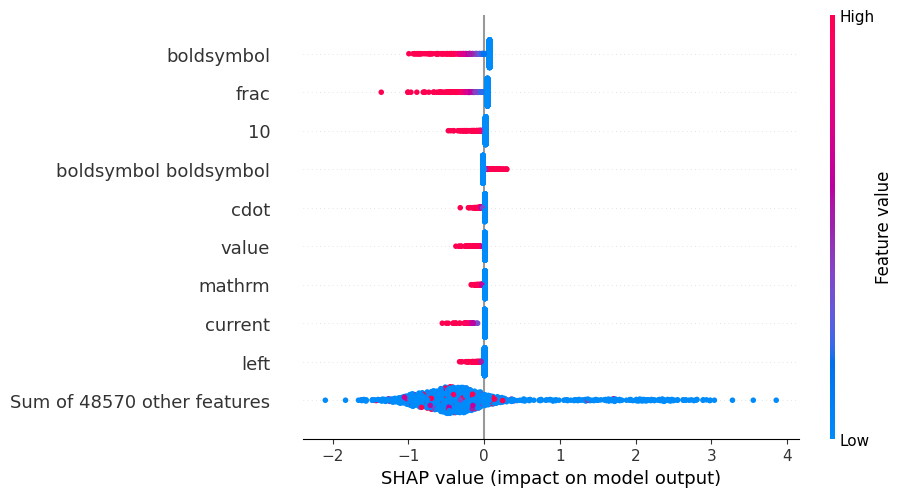

In [21]:
shap.plots.beeswarm(shap_values[:, :, 0])

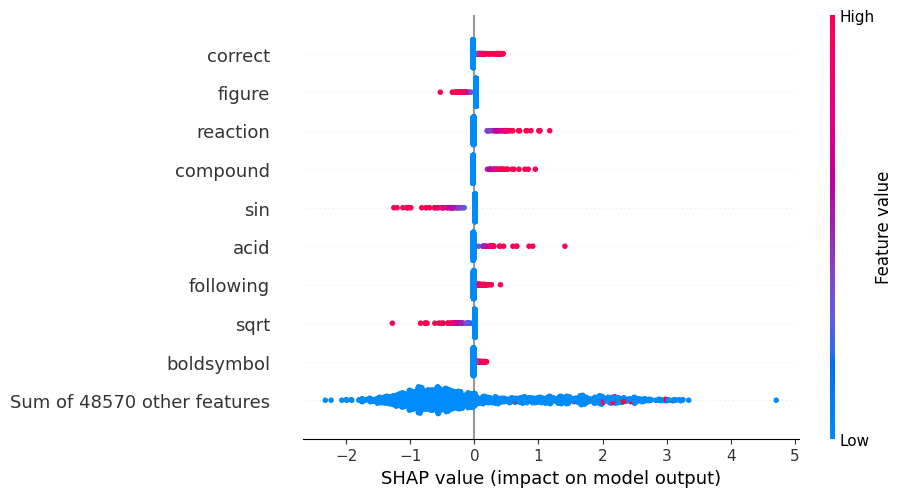

In [22]:
shap.plots.beeswarm(shap_values[:, :, 1])

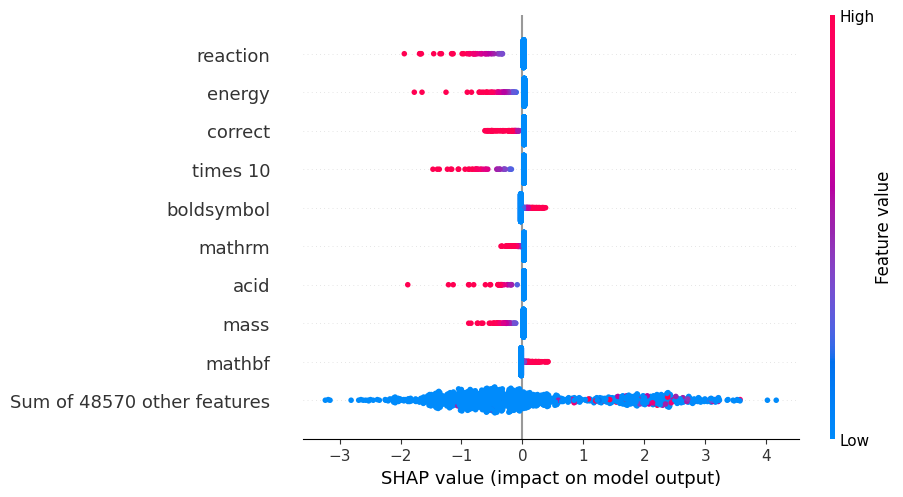

In [23]:
shap.plots.beeswarm(shap_values[:, :, 2])

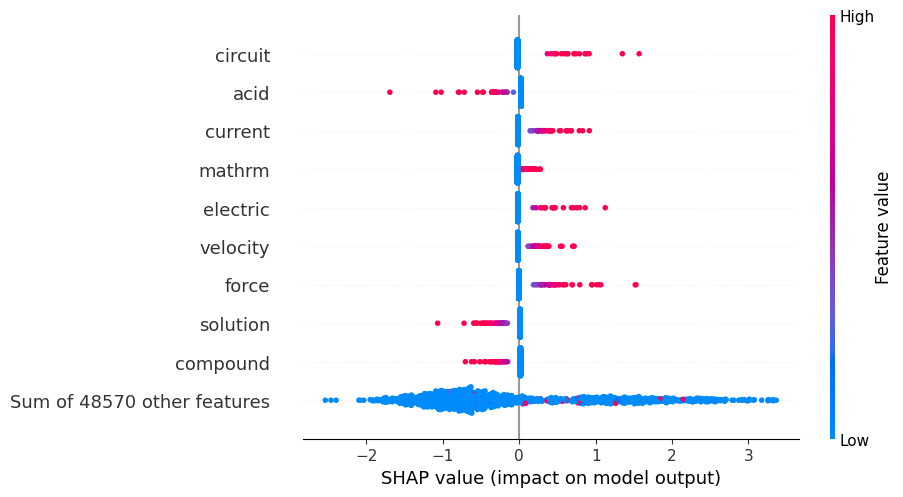

In [24]:
shap.plots.beeswarm(shap_values[:, :, 3])

We see how certain words contribute to certain classes which can help 